In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.stats.api as sms
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.regressionplots import plot_leverage_resid2
from stargazer.stargazer import Stargazer
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [2]:
interactions_file = Path('../..') / 'data' / 'my_intervention' / 'interventions.csv'
img_folder = Path('../..') / 'figs/'

In [3]:
df = pd.read_csv(interactions_file).set_index('day')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 245 entries, 2023-03-01 to 2023-07-02
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   estado                  245 non-null    object 
 1   vitimas                 245 non-null    int64  
 2   id_ocorrencia           245 non-null    int64  
 3   populacao_cidade        245 non-null    int64  
 4   id_ocorrencia_7d        245 non-null    float64
 5   user                    245 non-null    object 
 6   replies                 245 non-null    int64  
 7   weekend                 245 non-null    int64  
 8   intervention            245 non-null    int64  
 9   treatment               245 non-null    int64  
 10  intervention_treatment  245 non-null    int64  
dtypes: float64(1), int64(8), object(2)
memory usage: 23.0+ KB


In [4]:
df

,estado,vitimas,id_ocorrencia,populacao_cidade,id_ocorrencia_7d,user,replies,weekend,intervention,treatment,intervention_treatment
day,,,,,,,,,,,
2023-03-01,BA,6,3,972875,2.14,FogoCruzadoBA,3,0,0,0,0
2023-03-01,RJ,14,5,1747148,3.43,FogoCruzadoRJ,24,0,0,1,0
2023-03-02,BA,2,2,1419552,2.00,FogoCruzadoBA,4,0,0,0,0
2023-03-02,RJ,17,6,1469213,3.71,FogoCruzadoRJ,13,0,0,1,0
2023-03-03,BA,18,1,2675656,2.00,FogoCruzadoBA,3,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2023-06-30,RJ,2,3,2311823,2.29,FogoCruzadoRJ,33,0,1,1,1
2023-07-01,BA,4,2,1396851,2.14,FogoCruzadoBA,2,1,1,0,0
2023-07-01,RJ,11,5,1824291,2.29,FogoCruzadoRJ,11,1,1,1,1


# Visualize Y

<Axes: >

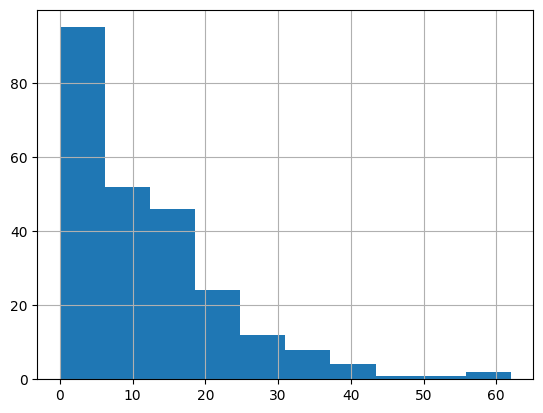

In [5]:
df.replies.hist()

In [6]:
avg_replies = df.replies.mean()


var_replies = df.replies.var()


print(f'Variance: {var_replies}')
print(f'Mean: {avg_replies}')


Variance: 116.94422883907664
Mean: 12.359183673469389


# Diff in diff

In [7]:
df.columns

Index(['estado', 'vitimas', 'id_ocorrencia', 'populacao_cidade',
       'id_ocorrencia_7d', 'user', 'replies', 'weekend', 'intervention',
       'treatment', 'intervention_treatment'],
      dtype='object')

In [8]:
mean_ba_before = df[(df.intervention == 0) & (df.treatment == 0)].replies.mean()
mean_rj_before = df[(df.intervention == 0) & (df.treatment == 1)].replies.mean()
mean_ba_after = df[(df.intervention == 1) & (df.treatment == 0)].replies.mean()
mean_rj_after = df[(df.intervention == 1) & (df.treatment == 1)].replies.mean()

print(f"Mean replies before intervention in BA: {mean_ba_before:.2f}")
print(f"Mean replies before intervention in RJ: {mean_rj_before:.2f}")
print(f"Mean replies after intervention in BA: {mean_ba_after:.2f}")
print(f"Mean replies after intervention in RJ: {mean_rj_after:.2f}")

rj_diff = mean_rj_after - mean_rj_before
print(f"Diff for RJ: {rj_diff:.2f}")
ba_diff = mean_ba_after - mean_ba_before
print(f"Diff for BA: {ba_diff:.2f}")

print(f"Diff-in-diff estimate: {rj_diff - ba_diff:.2f}")

Mean replies before intervention in BA: 6.06
Mean replies before intervention in RJ: 17.11
Mean replies after intervention in BA: 3.91
Mean replies after intervention in RJ: 24.20
Diff for RJ: 7.09
Diff for BA: -2.14
Diff-in-diff estimate: 9.23


# Plot y

In [9]:
df[df.treatment == 0].replies.cumsum()

day
2023-03-01      3
2023-03-02      7
2023-03-03     10
2023-03-04     10
2023-03-05     14
             ... 
2023-06-28    649
2023-06-29    650
2023-06-30    656
2023-07-01    658
2023-07-02    658
Name: replies, Length: 121, dtype: int64

# Regression model

In [10]:
df.head(10)

,estado,vitimas,id_ocorrencia,populacao_cidade,id_ocorrencia_7d,user,replies,weekend,intervention,treatment,intervention_treatment
day,,,,,,,,,,,
2023-03-01,BA,6,3,972875,2.14,FogoCruzadoBA,3,0,0,0,0
2023-03-01,RJ,14,5,1747148,3.43,FogoCruzadoRJ,24,0,0,1,0
2023-03-02,BA,2,2,1419552,2.00,FogoCruzadoBA,4,0,0,0,0
2023-03-02,RJ,17,6,1469213,3.71,FogoCruzadoRJ,13,0,0,1,0
2023-03-03,BA,18,1,2675656,2.00,FogoCruzadoBA,3,0,0,0,0
2023-03-03,RJ,2,2,3660087,3.43,FogoCruzadoRJ,15,0,0,1,0
2023-03-04,BA,7,4,719822,2.14,FogoCruzadoBA,0,1,0,0,0
2023-03-04,RJ,7,3,2309246,3.43,FogoCruzadoRJ,7,1,0,1,0
2023-03-05,BA,4,1,2675656,2.14,FogoCruzadoBA,4,1,0,0,0


In [11]:
rename_cols_dict = {
    'id_ocorrencia': 'number_cases',
    'vitimas': 'number_victims',
    'populacao_cidade': 'avg_population',
}

df = df.rename(columns=rename_cols_dict)

formula = 'replies ~ intervention + treatment + intervention_treatment + number_cases + number_victims + avg_population'

model = ols(formula, data=df).fit()


model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                replies   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     34.20
Date:                Fri, 28 Jul 2023   Prob (F-statistic):           1.16e-29
Time:                        17:46:04   Log-Likelihood:                -854.28
No. Observations:                 245   AIC:                             1723.
Df Residuals:                     238   BIC:                             1747.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  9.4298      2.800      3.368      0.001       3.914      14.946
intervention              -2.3894      1.615     -1.479      0.140      -5.572       0.793
treatment                 13.6663      2.219      6.160      0.000       9.295      18.037
intervention_treatment     9.6933      2.291      4.231      0.000       5.180      14.207
number_cases              -0.8984      0.749     -1.200      0.231      -2.373       0.576
number_victims             0.2127      0.164      1.296      0.196      -0.111       0.536
avg_population         -1.535e-06   8.23e-07     -1.866      0.063   -3.16e-06    8.55e-08
==============================================================================
Omnibus:                       83.019   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              278.751
Skew:                           1.419   Prob(JB):                     2.95e-61
Kurtosis:                       7.388   Cond. No.                     1.65e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.65e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Check assumptions

Text(0, 0.5, 'Residuals')

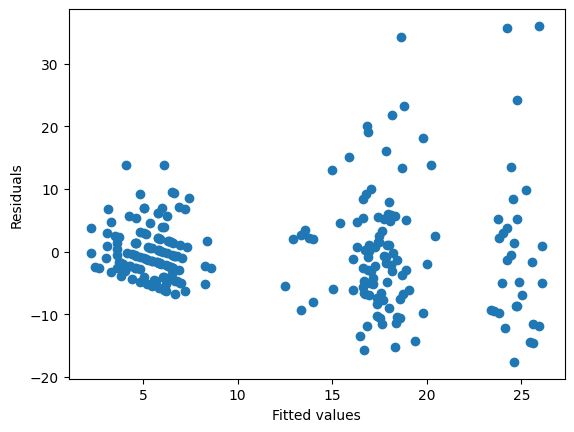

In [12]:
# residuals vs fitted values plot

plt.scatter(model.fittedvalues, model.resid)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')


In [13]:
# homostedasticity test using Breusch-Pagan test of non-constants variance

bp_test = sms.het_breuschpagan(model.resid, model.model.exog)

print(f"F-statistic: {bp_test[0]:.3f}, p-value: {bp_test[1]:.3f}")

if bp_test[1] > 0.05:
    print("The null hypothesis of equal variance is not rejected")
else:
    print("The null hypothesis of equal variance is rejected")

F-statistic: 31.749, p-value: 0.000
The null hypothesis of equal variance is rejected


/tmp/ipykernel_348215/1600637612.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


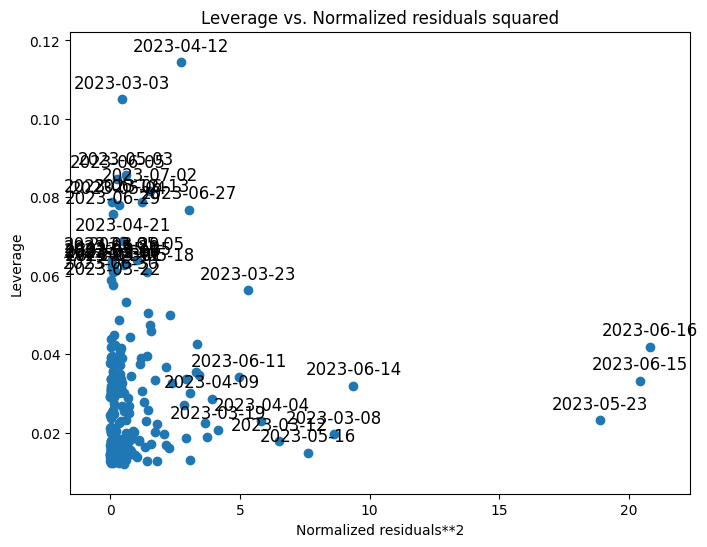

In [14]:
#  analysis of the Cook’s D statistic through an influence plot of residuals and leverage

fig, ax = plt.subplots(figsize=(8,6))

fig = plot_leverage_resid2(model, ax=ax)

fig.show()

# Binomial

In [15]:
df

,estado,number_victims,number_cases,avg_population,id_ocorrencia_7d,user,replies,weekend,intervention,treatment,intervention_treatment
day,,,,,,,,,,,
2023-03-01,BA,6,3,972875,2.14,FogoCruzadoBA,3,0,0,0,0
2023-03-01,RJ,14,5,1747148,3.43,FogoCruzadoRJ,24,0,0,1,0
2023-03-02,BA,2,2,1419552,2.00,FogoCruzadoBA,4,0,0,0,0
2023-03-02,RJ,17,6,1469213,3.71,FogoCruzadoRJ,13,0,0,1,0
2023-03-03,BA,18,1,2675656,2.00,FogoCruzadoBA,3,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2023-06-30,RJ,2,3,2311823,2.29,FogoCruzadoRJ,33,0,1,1,1
2023-07-01,BA,4,2,1396851,2.14,FogoCruzadoBA,2,1,1,0,0
2023-07-01,RJ,11,5,1824291,2.29,FogoCruzadoRJ,11,1,1,1,1


In [16]:
df['log_replies'] = np.log(df['replies'] + 1)

X = df[['intervention', 'treatment', 'intervention_treatment',
        'number_cases', 'number_victims', 'avg_population']]


X = X.rename(columns=rename_cols_dict)

X

,intervention,treatment,intervention_treatment,number_cases,number_victims,avg_population
day,,,,,,
2023-03-01,0,0,0,3,6,972875
2023-03-01,0,1,0,5,14,1747148
2023-03-02,0,0,0,2,2,1419552
2023-03-02,0,1,0,6,17,1469213
2023-03-03,0,0,0,1,18,2675656
...,...,...,...,...,...,...
2023-06-30,1,1,1,3,2,2311823
2023-07-01,1,0,0,2,4,1396851
2023-07-01,1,1,1,5,11,1824291


In [17]:
y = df['replies']

X = sm.add_constant(X)

# rename "const" to "Intercept"
X = X.rename(columns={'const': 'Intercept'})

# Fit negative binomial regression
negmodel = sm.GLM(y, X, family=sm.families.NegativeBinomial()).fit()

negmodel.summary()


/home/abitporu/Documents/crossfire/.venv/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                replies   No. Observations:                  245
Model:                            GLM   Df Residuals:                      238
Model Family:        NegativeBinomial   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -825.23
Date:                Fri, 28 Jul 2023   Deviance:                       121.62
Time:                        17:46:04   Pearson chi2:                     94.3
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3100
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1.9858      0.366      5.428      0.000       1.269       2.703
intervention              -0.4541      0.223     -2.034      0.042      -0.892      -0.017
treatment                  1.1752      0.290      4.056      0.000       0.607       1.743
intervention_treatment     0.8315      0.305      2.729      0.006       0.234       1.429
number_cases              -0.0393      0.098     -0.402      0.687      -0.231       0.152
number_victims             0.0116      0.022      0.538      0.590      -0.031       0.054
avg_population         -9.789e-08   1.07e-07     -0.914      0.361   -3.08e-07    1.12e-07
==========================================================================================
"""

# Export LaTeX table

In [18]:
stargazer = Stargazer([model,negmodel])

# add name for each model
stargazer.custom_columns(['Ordinary Least Square', 'Negative Binomial'], [1, 1])
stargazer.cov_spacing = 10

covariate_dict = {
    'avg_population': 'avg\_population',
    'number_cases': 'number\_cases',
    'intervention_treatment': 'intervention\_treatment',
    'number_victims': 'number\_victims',
}

stargazer.rename_covariates(covariate_dict)
# get Pseudo R-squ. (CS) from the negative binomial model]
negr2 = round(negmodel.pseudo_rsquared(),3)
modelr2 = round(model.rsquared,3)

# add note
# stargazer.add_custom_notes([
#     "$R^2$ for model 2 is the Pseudo $R^2$ (Cox-Snell)",
# ])

stargazer.show_confidence_intervals(True)

## add the name of the dependent variable
stargazer.dependent_variable_name('replies')

In [19]:
def custom_output(latex_txt, modelr2, negr2):
    new_line = " Pseudo $R^2$ (Cox-Snell) & & " + str(negr2) + r" \\"

    # Split the LaTeX table into lines
    lines = latex_txt.split('\n')

    # Replace the tabular environment with a tabularx environment
    for i in range(len(lines)):
        if lines[i].strip().startswith(r'\begin{tabular}'):
            lines[i] = r'\begin{tabular*}{\textwidth}{@{\extracolsep{\fill}} l@{\hspace{20pt}} c c}'
        elif "Adjusted" in lines[i] and "Residual" in lines[i+1]:
            # append new_line
            lines.insert(i+1, new_line)  
        # replace \end{tabular}
        elif lines[i].strip() == r'\end{tabular}':
            lines[i] = r'\end{tabular*}'

    # Correct alignment from right to left for specific lines and change the format
    for i in range(len(lines)):
        if "\\multicolumn{2}{l}" in lines[i] and "$^{*}$p$<$0.1;" in lines[i]:
            lines[i] = r'\textit{Note:} & $^{*}$p$<$0.1; $^{**}$p$<$0.05; $^{***}$p$<$0.01 & \\'

    # Insert the caption line before the \end{table}
    for i in range(len(lines)):
        if lines[i].strip() == r'\end{table}':
            lines.insert(i, r'\caption{\label{regression-results}Difference-in-difference regression results.}')
            break

    # Join the lines back together into a single string
    latex_txt = '\n'.join(lines)

    print(latex_txt)


custom_output(stargazer.render_latex(), modelr2, negr2)


\begin{table}[!htbp] \centering
\begin{tabular*}{\textwidth}{@{\extracolsep{\fill}} l@{\hspace{20pt}} c c}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{2}{c}{\textit{Dependent variable: replies}} \
\cr \cline{2-3}
\\[-1.8ex] & \multicolumn{1}{c}{Ordinary Least Square} & \multicolumn{1}{c}{Negative Binomial}  \\
\\[-1.8ex] & (1) & (2) \\
\hline \\[-1.8ex]
 Intercept & 9.430$^{***}$ & 1.986$^{***}$ \\
& (3.914 , 14.946) & (1.269 , 2.703) \\[10em]
 avg\_population & -0.000$^{*}$ & -0.000$^{}$ \\
& (-0.000 , 0.000) & (-0.000 , 0.000) \\[10em]
 intervention & -2.389$^{}$ & -0.454$^{**}$ \\
& (-5.572 , 0.793) & (-0.892 , -0.017) \\[10em]
 intervention\_treatment & 9.693$^{***}$ & 0.832$^{***}$ \\
& (5.180 , 14.207) & (0.234 , 1.429) \\[10em]
 number\_cases & -0.898$^{}$ & -0.039$^{}$ \\
& (-2.373 , 0.576) & (-0.231 , 0.152) \\[10em]
 number\_victims & 0.213$^{}$ & 0.012$^{}$ \\
& (-0.111 , 0.536) & (-0.031 , 0.054) \\[10em]
 treatment & 13.666$^{***}$ & 1.175$^{***}$ \\
& (9.295 , 18.03

# QQplot


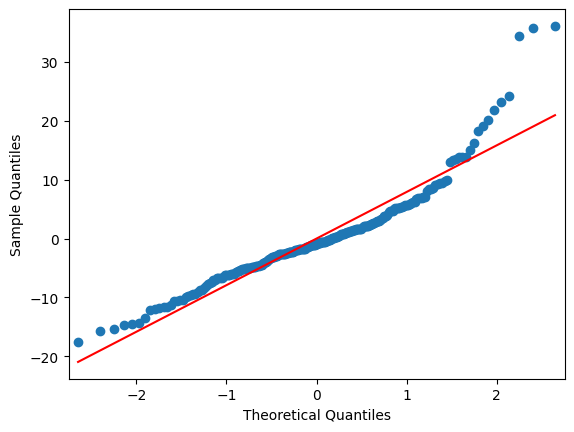

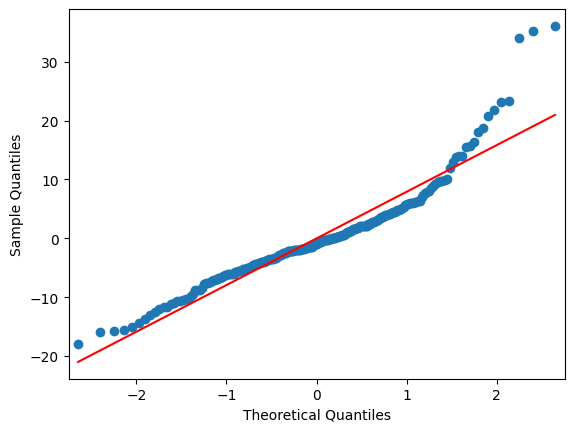

In [20]:
import plotly.graph_objects as go
from statsmodels.graphics.gofplots import qqplot

def generate_qqplot(residuals):
    qqplot_data = qqplot(residuals, line='s').gca().lines

    fig = go.Figure()

    fig.add_trace({
        'type': 'scatter',
        'x': qqplot_data[0].get_xdata(),
        'y': qqplot_data[0].get_ydata(),
        'mode': 'markers',
    })

    fig.add_trace({
        'type': 'scatter',
        'x': qqplot_data[1].get_xdata(),
        'y': qqplot_data[1].get_ydata(),
        'mode': 'lines',
    })

    fig.update_layout(
        xaxis=dict(
            title='Theoretical quantities',
            zeroline=False
        ),
        yaxis=dict(
            title='Sample quantities'
        ),
        showlegend=False,
        width=800,
        height=700,
        template='presentation'
    )
    fig.update_xaxes(showline=True,
            linewidth=1,
            linecolor='black',
            mirror=True)

    fig.update_yaxes(showline=True,
            linewidth=1,
            linecolor='black',
            mirror=True)
    
    return fig

qqplot_ols = generate_qqplot(model.resid)
qqplot_neg = generate_qqplot(negmodel.resid_response)
qqplot_neg.show()

In [21]:
qqplotfilename = img_folder / 'qqplot.png'
qqplotfilenameneg = img_folder / 'qqplotneg.png'

qqplot_ols.write_image(qqplotfilename, width=1000, height=600, scale=2)
qqplot_neg.write_image(qqplotfilenameneg, width=1000, height=600, scale=2)